In [296]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
from collections import Counter
import matplotlib.pyplot as plt

In [297]:
def getDigitsDataset():
    # Load the digits dataset
    digits = datasets.load_digits()
    digitData = pd.DataFrame(data=np.c_[digits.data, digits.target], columns=np.arange(64).tolist() + ["target"])
    return digitData

In [298]:
def getTitanicDataset():
    # Load the dataset ensuring that pandas correctly interprets the first row as headers
    data = pd.read_csv('dataset/titanic.csv')

    # Drop the 'Name' column if it exists
    data.drop('Name', axis=1, inplace=True)
    
    # Isolate the target column and rename it
    target = data['Survived']
    data.drop('Survived', axis=1, inplace=True)
    
    # Select columns to be one-hot encoded
    categorical_features = ['Sex', 'Pclass']
    
    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False)  # Adjusted here for the new version of scikit-learn
    
    # Fit and transform the categorical features
    encoded_features = encoder.fit_transform(data[categorical_features])
    
    # Create a DataFrame with the encoded features, ensure column names are intuitive
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
    
    # Drop original categorical columns from data and concatenate the new encoded features
    data.drop(categorical_features, axis=1, inplace=True)
    data = pd.concat([data, encoded_df], axis=1)
    
    # Append the target column back to the DataFrame
    data['target'] = target

    return data

In [299]:
def normalizeDataset(feature_train, feature_test):
    max_vals = np.max(feature_train, axis=0)
    min_vals = np.min(feature_train, axis=0)
    range_vals = max_vals - min_vals
    # Avoid division by zero: where range_vals is zero, make it 1 (identity normalization)
    range_vals[range_vals == 0] = 1
    feature_train_normalized = (feature_train - min_vals) / range_vals
    feature_test_normalized = (feature_test - min_vals) / range_vals
    
    return feature_train_normalized, feature_test_normalized

In [300]:
def calculateDistance(feature1, feature2):
    dist = np.sqrt(np.sum((feature1 - feature2)**2))
    
    return dist

In [301]:
# def runKnnAlgo(featureData1, featureData2, labelData, k):
#     observedResult = []
#     for i in range(len(featureData1)):
#         distance = []
#         topKIndexArray = []
#         kLabelList = []
#         for j in range(len(featureData2)):
#             distance.append(calculateDistance(featureData1[i], featureData2[j]))
#         topKIndexArray = np.argsort(distance)[:k]
#         kLabelList = [labelData[m] for m in topKIndexArray]
#         predictedDigit = Counter(kLabelList).most_common(1)[0][0]
#         observedResult.append(predictedDigit)
    
#     return observedResult

In [302]:
def runKnnAlgo(featureData1, featureData2, labelData, k):
    observedResult = []
    for i in range(len(featureData1)):
        distance = []
        topKIndexArray = []
        kLabelList = []
        for j in range(len(featureData2)):
            distance.append(calculateDistance(featureData1.iloc[i], featureData2.iloc[j]))
        topKIndexArray = np.argsort(distance)[:k]
        kLabelList = [labelData.iloc[m] for m in topKIndexArray]
        predictedDigit = Counter(kLabelList).most_common(1)[0][0]
        observedResult.append(predictedDigit)
    return observedResult

In [303]:
def custom_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    accuracy = correct_predictions / total_predictions
    return accuracy


In [304]:
def custom_f1_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))  # True Positives
    fp = np.sum((y_true == 0) & (y_pred == 1))  # False Positives
    fn = np.sum((y_true == 1) & (y_pred == 0))  # False Negatives

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1


In [305]:
def custom_f1_score_multiclass(y_true, y_pred, classes):
    f1_scores = []
    for cls in classes:
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)

    macro_f1 = np.mean(f1_scores)
    return macro_f1

In [306]:
# def evaluateUsingStratifiedKFold(data, k, normalizeData):
#     accuracies = []
#     f1_scores = []
#     skf = StratifiedKFold(n_splits=10)
#     classes = np.unique(data['target'])  # Get unique classes for F1 calculation

#     # Split the data using stratified K-Fold
#     for train_index, test_index in skf.split(data.iloc[:, :-1], data.iloc[:, -1]):
#         feature_train, feature_test = data.iloc[train_index, :-1].values, data.iloc[test_index, :-1].values
#         label_train, label_test = data.iloc[train_index, -1].values, data.iloc[test_index, -1].values

#         # Normalize data if required
#         if normalizeData:
#             feature_train, feature_test = normalizeDataset(feature_train, feature_test)

#         # Run KNN algorithm
#         predictedLabels = runKnnAlgo(feature_test, feature_train, label_train, k)

#         # Evaluate the model using custom functions
#         acc = custom_accuracy(label_test, predictedLabels)
#         f1 = custom_f1_score_multiclass(label_test, predictedLabels, classes)

#         accuracies.append(acc)
#         f1_scores.append(f1)

#     return accuracies, f1_scores

In [307]:
def custom_stratified_kfold(data, num_folds):
    # Initialize folds
    folds = [[] for _ in range(num_folds)]
    # Get the unique classes and their counts
    class_counts = data['target'].value_counts()
    # Calculate the number of elements per fold per class
    per_fold_counts = (class_counts / num_folds).astype(int)
    
    # Iterate over each class to distribute its elements into folds
    for label, count in class_counts.items():
        # Filter data for the current class
        class_data = data[data['target'] == label]
        # Shuffle the class data
        class_data = class_data.sample(frac=1).reset_index(drop=True)
        # Assign elements to each fold
        for i in range(num_folds):
            start_idx = i * per_fold_counts[label]
            if i == num_folds - 1:
                # Last fold takes the remainder of the division
                folds[i].extend(class_data.iloc[start_idx:].index.tolist())
            else:
                end_idx = start_idx + per_fold_counts[label]
                folds[i].extend(class_data.iloc[start_idx:end_idx].index.tolist())
    return folds

def evaluateUsingCustomStratifiedKFold(data, k, normalizeData):
    accuracies = []
    f1_scores = []
    fold_indices = custom_stratified_kfold(data, k)
    for i in range(k):
        test_idx = fold_indices[i]
        train_idx = [idx for j in range(k) if j != i for idx in fold_indices[j]]
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]
        if normalizeData:
            feature_train, feature_test = normalizeDataset(train_data.drop('target', axis=1), test_data.drop('target', axis=1))
        else:
            feature_train, feature_test = train_data.drop('target', axis=1), test_data.drop('target', axis=1)
        train_labels = train_data['target']
        test_labels = test_data['target']
        predictedLabels = runKnnAlgo(feature_test, feature_train, train_labels, 3)
        acc = custom_accuracy(test_labels, predictedLabels)
        f1 = custom_f1_score_multiclass(test_labels, predictedLabels, np.unique(data['target']))
        accuracies.append(acc)
        f1_scores.append(f1)
    return accuracies, f1_scores

In [308]:
def plot_k_vs_metrics(k_values, accuracies, f1_scores):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(k_values, accuracies, label='Accuracy', marker='o', linestyle='-')
    plt.title('K vs. Accuracy')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(k_values, f1_scores, label='F1 Score', marker='o', linestyle='-')
    plt.title('K vs. F1 Score')
    plt.xlabel('k')
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

Net Average Accuracy for all Ks: 0.9705713318052641
Net F1 Score for all Ks: 0.9684013305100465


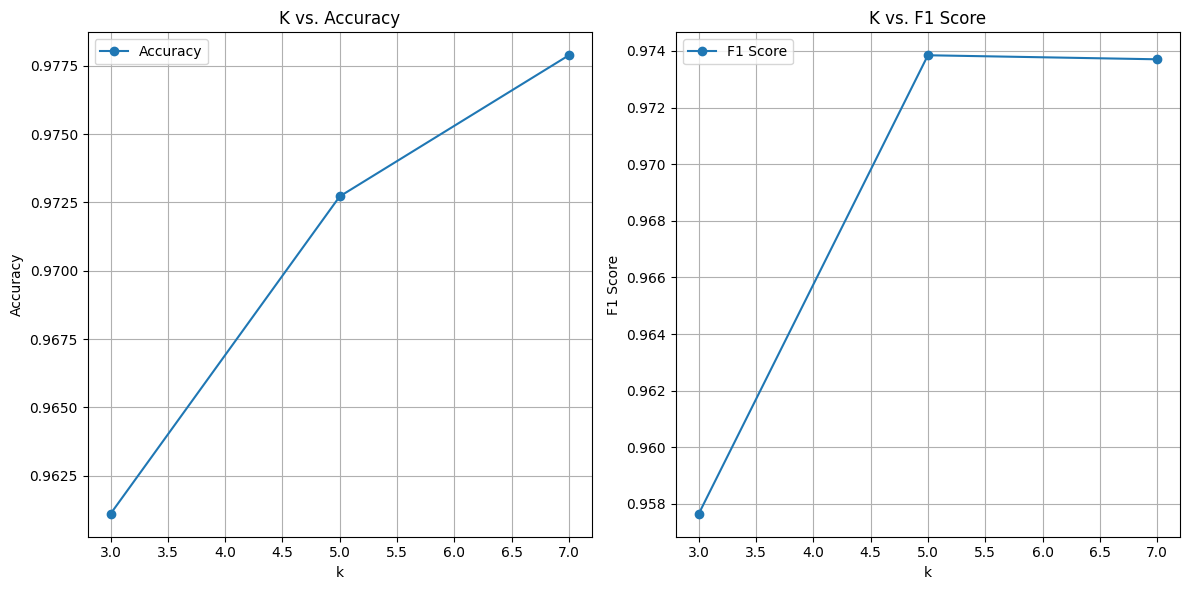

In [309]:
digitData = getDigitsDataset()
k_values = [3, 5, 7]
all_accuracies = []
all_f1_scores = []
for k in k_values:
    accuracies, f1_scores = evaluateUsingCustomStratifiedKFold(digitData, k, normalizeData=True)
    all_accuracies.append(np.mean(accuracies))
    all_f1_scores.append(np.mean(f1_scores))
print(f"Net Average Accuracy for all Ks: {np.mean(all_accuracies)}")
print(f"Net F1 Score for all Ks: {np.mean(all_f1_scores)}")
plot_k_vs_metrics(k_values, all_accuracies, all_f1_scores)

**K: 3**

**Average Accuracy: 0.7734520344689836**

** Average F1 Score: 0.7606543653613816**

**K: 5**

**Average Accuracy: 0.7677745163021178**

** Average F1 Score: 0.7522140383078119**

**K: 7**

**Average Accuracy: 0.7599749739311782**

** Average F1 Score: 0.7448496120530458**

Net Average Accuracy for all Ks: 0.7670671749007599
Net F1 Score for all Ks: 0.7525726719074131


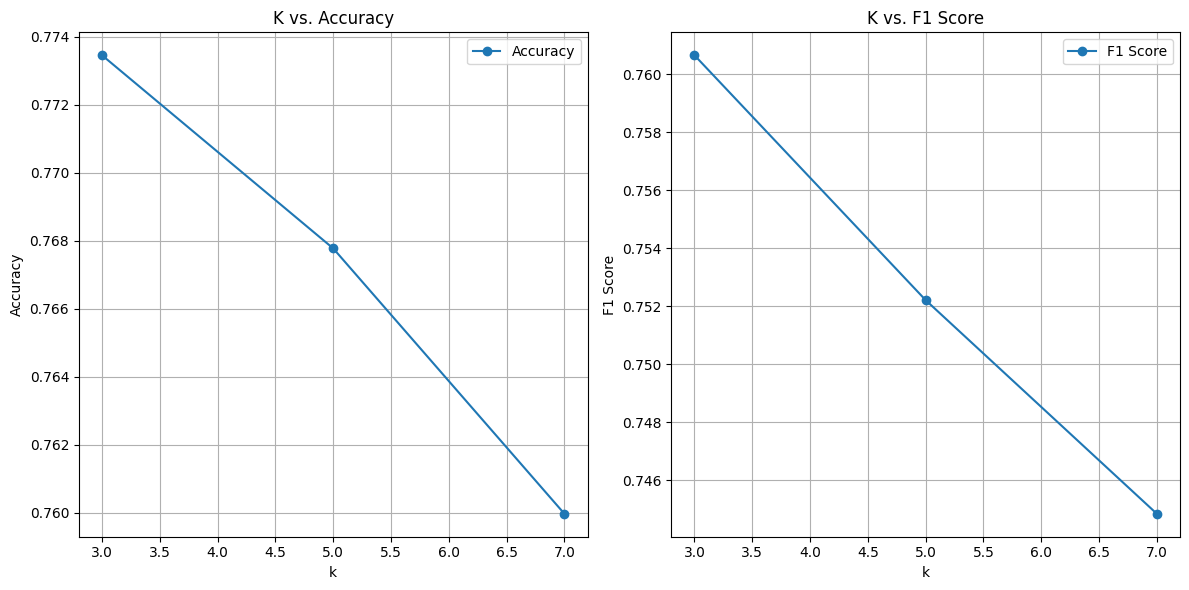

In [310]:
titanicData = getTitanicDataset()
k_values = [3, 5, 7]
all_accuracies = []
all_f1_scores = []
for k in k_values:
    accuracies, f1_scores = evaluateUsingCustomStratifiedKFold(titanicData, k, normalizeData=True)
    print(f"**K: {k}**\n")
    print(f"**Average Accuracy: {np.mean(accuracies)}**\n")
    print(f"** Average F1 Score: {np.mean(f1_scores)}**\n")
    all_accuracies.append(np.mean(accuracies))
    all_f1_scores.append(np.mean(f1_scores))
print(f"Net Average Accuracy for all Ks: {np.mean(all_accuracies)}")
print(f"Net F1 Score for all Ks: {np.mean(all_f1_scores)}")
plot_k_vs_metrics(k_values, all_accuracies, all_f1_scores)